# Introdução

Esse caderno tem por objetivo a criação de um modelo básico de treinamento, utilizando o classificador [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), que faça a predição de homologação de arquivamentos de procedimentos enviados à 1A.CAM do MPF.

Esse modelo usará apenas os metadados dos procedimentos, sem fazer nenhum processamento textual.

O objetivo desse modelo é servir como um *baseline* de comparações para implementações futuras.


**Nota**: os dados desse modelo foram recuperados de procedimentos que tiveram suas deliberações realizadas após o dia 02/07/2018, data em que a nova composição tomou posse na 1A.CAM.

# Carga de dados e pré-processamento

Vamos fazer a carga dos dados e fazer um pré-processamento tradicional (remoção de atributos que não interessam, criação de variáveis categóricas etc.)

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

from sklearn import metrics

In [3]:
PATH = "../data/"
df_original = pd.read_json(f'{PATH}/1A.CAM.homologacao-arquivamento.json')

In [4]:
len(df_original)

6213

In [5]:
df_original.columns

Index(['areaAtuacao', 'classe', 'dataAutuacao', 'dataEntrada', 'homologado',
       'id', 'identificadorPecaPromocao', 'itemCnmp', 'membroResponsavel',
       'municipio', 'prioritario', 'procedimento', 'quantidadeConversoes',
       'quantidadeProvidencias', 'textosProvidencias', 'urgente'],
      dtype='object')

In [6]:
df_original.describe()

,areaAtuacao,classe,homologado,id,identificadorPecaPromocao,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente
count,6.213000e+03,6213.000000,6213.000000,6.213000e+03,5.990000e+03,6.213000e+03,5990.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000
mean,3.241772e+02,2.528730,0.984870,6.732199e+07,7.758961e+07,2.375876e+04,38414.392654,2892.452117,0.006921,2.032191,7.223724,0.006921
std,2.537449e+04,0.924041,0.122078,1.321553e+07,6.529438e+06,2.086008e+05,34287.237070,1672.507693,0.082911,1.397010,8.707997,0.082911
min,1.000000e+00,1.000000,0.000000,2.842880e+06,2.648738e+07,2.000000e+00,752.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+00,2.000000,1.000000,6.406698e+07,7.297336e+07,1.521000e+03,13606.000000,1387.000000,0.000000,1.000000,2.000000,0.000000
50%,2.000000e+00,3.000000,1.000000,7.001298e+07,7.711780e+07,1.581000e+03,25063.000000,3078.000000,0.000000,2.000000,5.000000,0.000000
75%,2.000000e+00,3.000000,1.000000,7.543734e+07,8.379348e+07,1.892000e+03,53327.000000,4321.000000,0.000000,3.000000,9.000000,0.000000
max,2.000085e+06,61.000000,1.000000,8.756619e+07,8.810570e+07,2.007548e+06,127563.000000,5768.000000,1.000000,13.000000,161.000000,1.000000


In [7]:
len(df_original[df_original.identificadorPecaPromocao.isnull()])

223

In [8]:
df_work = df_original.copy()

In [9]:
# elementos com peça de promoção de arquivamento nulos não nos interessam
df_work.dropna(subset=['identificadorPecaPromocao'], inplace=True)
df_work.reset_index(drop=True, inplace=True)

In [10]:
len(df_work[df_work.identificadorPecaPromocao.isnull()])

0

In [11]:
# nessa primeira passada, essas colunas não nos interessam
removed_columns = ['id', 'procedimento', 'textosProvidencias', 'identificadorPecaPromocao']
df_work = df_work.drop(columns=removed_columns)
df_work.sample(10)

,areaAtuacao,classe,dataAutuacao,dataEntrada,homologado,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente
2978,2,2,13-09-2016,23-05-2017,1,1580,64245.0,4477,0,0,2,0
788,2,3,06-10-2016,18-06-2018,1,1864,18652.0,3078,0,3,12,0
3924,2,2,11-03-2016,30-01-2017,1,1515,53312.0,5504,0,2,2,0
133,5,3,11-09-2014,02-08-2018,1,1525,10297.0,810,0,1,5,0
150,2,2,01-03-2018,02-08-2018,1,1521,3768.0,1214,0,2,5,0
491,2,2,31-10-2017,09-07-2018,1,1556,20391.0,4966,0,2,4,0
1281,2,3,19-01-2016,10-05-2018,1,1543,18836.0,3113,0,4,22,0
1669,2,3,16-05-2014,19-03-2018,1,3147,87662.0,5115,0,3,31,0
2292,2,2,18-05-2017,15-09-2017,1,1102,3591.0,4369,0,1,1,0
2921,2,3,27-01-2017,25-05-2017,1,1567,23549.0,4638,0,1,3,0


In [12]:
df_work.describe()

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente
count,5.990000e+03,5990.000000,5990.000000,5.990000e+03,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000
mean,3.361636e+02,2.535058,0.985309,2.357373e+04,38414.392654,2898.332554,0.007012,2.045409,7.221870,0.007012
std,2.584250e+04,0.932175,0.120323,2.077185e+05,34287.237070,1669.009741,0.083449,1.394695,8.570688,0.083449
min,1.000000e+00,1.000000,0.000000,2.000000e+00,752.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+00,2.000000,1.000000,1.521000e+03,13606.000000,1428.250000,0.000000,1.000000,3.000000,0.000000
50%,2.000000e+00,3.000000,1.000000,1.581000e+03,25063.000000,3083.000000,0.000000,2.000000,5.000000,0.000000
75%,2.000000e+00,3.000000,1.000000,1.892000e+03,53327.000000,4335.000000,0.000000,3.000000,9.000000,0.000000
max,2.000085e+06,61.000000,1.000000,2.007548e+06,127563.000000,5768.000000,1.000000,13.000000,161.000000,1.000000


In [13]:
# tratando os nulos
df_work.fillna(-1, inplace=True)

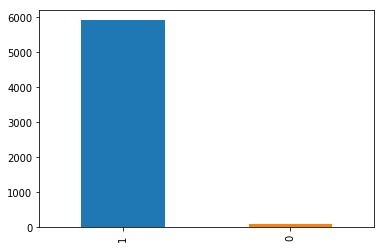

In [14]:
df_work['homologado'].value_counts().plot.bar()

### Classes desbalanceadas!!!

Conforme podemos ver acima, as classes desse problema são altamente desbalanceadas - apenas 1.46% do conjunto de dados representam procedimentos que não foram homologados.

Isso, muito provavelmente, causará problemas no treino do modelo. Mas, inicialmente, vamos ignorar isso e seguir com o nosso treino.

In [15]:
# conversão para datas
df_work['dataAutuacao'] = pd.to_datetime(df_work['dataAutuacao'],infer_datetime_format=True)
df_work['dataEntrada'] = pd.to_datetime(df_work['dataEntrada'],infer_datetime_format=True)

In [16]:
# vamos criar uma variável derivada, representando a quantidade de dias desde a autuação até a entrada
df_work['diasTranscorridos'] = 0
for index in range(len(df_work)):
    df_work.loc[index, 'diasTranscorridos'] =  (df_work.loc[index, 'dataEntrada'] - df_work.loc[index, 'dataAutuacao']).days

In [17]:
df_work.sample(10)

,areaAtuacao,classe,dataAutuacao,dataEntrada,homologado,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente,diasTranscorridos
387,2,3,2014-08-08,2018-07-18,1,1669,53309.0,3100,0,5,11,0,1440
697,2,3,2017-05-04,2018-06-20,1,3150,127539.0,5023,0,4,6,0,412
1345,2,3,2015-11-12,2018-05-14,1,1581,18836.0,3113,0,4,18,0,914
3700,2,3,2015-10-20,2017-03-13,1,1772,20872.0,4710,0,1,3,0,510
579,2,2,2018-01-16,2018-07-09,1,852,127541.0,4960,0,2,4,0,174
906,2,3,2015-06-08,2018-06-11,1,1507,33435.0,1443,0,4,14,0,1099
4778,2,3,2015-07-10,2016-06-29,1,1567,17663.0,2579,0,0,4,0,355
2531,2,3,2016-09-23,2017-07-26,1,3147,22600.0,4808,0,1,7,0,306
3182,2,3,2014-11-20,2017-05-08,1,1521,127558.0,291,0,3,4,0,900
1764,2,3,2015-01-06,2018-03-06,1,750,87444.0,3903,0,3,4,0,1155


In [19]:
removed_columns = ['homologado', 'dataEntrada', 'dataAutuacao']
features = [c for c in df_work.columns if c not in removed_columns]

model = RandomForestClassifier()
model.fit(df_work[features], df_work['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
model.score(df_work[features], df_work['homologado'])

0.998330550918197

In [21]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df_work, random_state=42)
train.shape, valid.shape

((4492, 13), (1498, 13))

In [22]:
model.fit(train[features], train['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

In [35]:
from sklearn.metrics import accuracy_score

def print_score():
    print(accuracy_score(train['homologado'], train_preds), accuracy_score(valid['homologado'], valid_preds))

print_score()

0.9984416740872663 0.9806408544726302


### Primeira avaliação

Embora não tenha ocorrido overfitting no treinamento e o *score* final tenha sido alto, cabe utilizar uma outra medida para assegurar a qualidade do modelo. Vamos utilizar a ** *matriz de confusão* **.



In [25]:
from sklearn.metrics import confusion_matrix

confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   28],
       [   1, 1469]])

In [26]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   28,    1, 1469])

In [27]:
len(valid[valid['homologado']==1]), len(valid[valid['homologado']==0])

(1470, 28)

Ao utilizar o ravel(), temos uma saída do tipo (tn, fp, fn, tp). De onde vemos que:


- tivemos 0 tn - *true negative*; ou seja, o modelo não conseguiu acertar nenhum dos que não tiveram o arquivamento homologado;
- tivemos 28 fp - *false positive*; 28 que não tiveram o arquivamento homologado e o modelo classificou como homologado;
- tivemos 1 fn - *false negative*; foram homologados e o modelo marcou como não homologados;
- tivemos 1469 tp - *true positive*; foram homologados e o modelo marcou corretamente.

Logo, apesar da acurácia do modelo aparentar ser muito boa (98% no validation set), o **modelo não sabe lidar com os não arquivamentos** - não acertou nenhum dos que realmente não foram homologados. Ou seja dos 22 que não foram homologados, o modelo errou todos e ainda marcou 4 não homologados de forma errada.

Fica claro que somente essas features não ajudam na descoberta - o texto da íntegra é, segundo a área negocial, realmente o mais importante.

Vamos continuar avaliando esse modelo.

## Feature importances

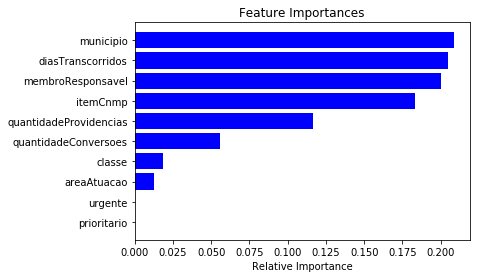

In [36]:
import matplotlib.pyplot as plt

def plot_fi(feature_importances=model.feature_importances_):
    feature_importances = model.feature_importances_
    indices = np.argsort(feature_importances)
    
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
plot_fi(model.feature_importances_)

O modelo está dando muita importância ao município que, considerando o bom senso e um pouco de domínio negocial, não faz sentido - o município não deveria interferir.

Lembrar: criar uma coluna para cada uma das listas de palavras-chaves, indicando ausência ou presença

In [38]:
# Vou retirar as colunas com poucas importância
removed_columns = ['homologado', 'dataEntrada', 'dataAutuacao', 'urgente', 'prioritario']
features = [c for c in df_work.columns if c not in removed_columns]

model = RandomForestClassifier()

model.fit(train[features], train['homologado'])

train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

0.9993321460373998 0.9813084112149533


In [39]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   28,    0, 1470])

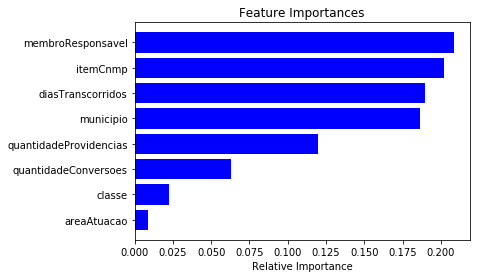

In [40]:
plot_fi()

Com as novas features, retirando a urgente e a prioritário, não houve mais falsos negativos, mas ainda não conseguimos prever corretamente os não homologados.

Vou retirar a coluna município, pois, ao meu ver, ela não nos parece adequada - e o modelo continua dando muita importância a ela.

In [43]:
removed_columns.append('municipio')
removed_columns

features = [c for c in df_work.columns if c not in removed_columns]

model.fit(train[features], train['homologado'])

train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

0.998886910062333 0.9806408544726302


In [44]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   28,    1, 1469])

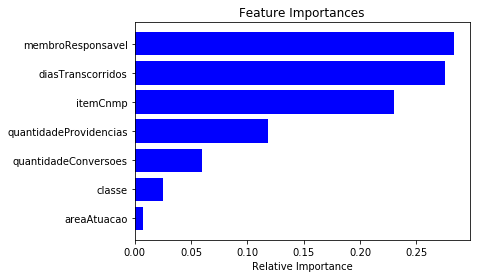

In [45]:
plot_fi()

Ao retirar a coluna município, o desempenho voltou ao inicial.

Vamos criar um modelo ainda mais simples, apenas com as features cuja importância seja maior que 5%.

In [53]:
model = RandomForestClassifier()

important_features = ['membroResponsavel', 'diasTranscorridos', 'itemCnmp', 'quantidadeProvidencias', 'quantidadeConversoes']
model.fit(train[important_features], train['homologado'])

train_preds = model.predict(train[important_features])
valid_preds = model.predict(valid[important_features])

print_score()

0.9984416740872663 0.9813084112149533


In [54]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   28,    0, 1470])

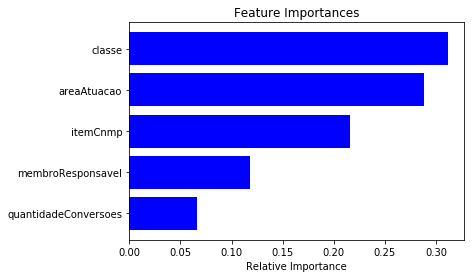

In [55]:
plot_fi()

Somente com as features importantes acima, o desempenho voltou ao melhor obtido até agora (acurácia boa, mas muito ruim em lidar com os não homologados). 

Vamos fazer mais um teste, apenas com as top-3 features

In [56]:
important_features = ['classe', 'areaAtuacao', 'itemCnmp']

model = RandomForestClassifier()
model.fit(train[important_features], train['homologado'])

train_preds = model.predict(train[important_features])
valid_preds = model.predict(valid[important_features])

print_score()

0.988646482635797 0.9779706275033377


In [57]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   28,    5, 1465])

Com o modelo mais simples, o desempenho foi o pior de todos até agora. Vamos passar a considerar o texto.

## Considerando as providências realizadas

In [60]:
df_work = df_original.copy()

df_work.dropna(subset=['identificadorPecaPromocao'], inplace=True)
df_work.reset_index(drop=True, inplace=True)

df_work['dataAutuacao'] = pd.to_datetime(df_work['dataAutuacao'],infer_datetime_format=True)
df_work['dataEntrada'] = pd.to_datetime(df_work['dataEntrada'],infer_datetime_format=True)

df_work['diasTranscorridos'] = 0
for index in range(len(df_work)):
    df_work.loc[index, 'diasTranscorridos'] =  (df_work.loc[index, 'dataEntrada'] - df_work.loc[index, 'dataAutuacao']).days

removed_columns = ['id', 'procedimento', 'identificadorPecaPromocao', 'prioritario', 'urgente', 'dataAutuacao', 'dataEntrada']
df_work = df_work.drop(columns=removed_columns)
df_work.fillna(-1, inplace=True)

    
df_work.sample(10)

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,textosProvidencias,diasTranscorridos
4585,2,3,1,1521,53306.0,2918,2,7,"Análise do arquivamento,Converta-se em Inquéri...",870
4882,2,3,1,2338,7998.0,3113,3,8,"Converta-se em Inquérito Civil(IC).,Oficie-se....",404
586,5,2,1,1654,64229.0,3042,2,5,"Oficie-se.,Prorroga-se o prazo de finalização ...",204
1136,2,2,1,2007098,87522.0,1727,1,1,Converta-se em Procedimento Preparatório(PP).,126
1019,2,3,1,1514,53245.0,5039,5,12,"Despacho Simplificado,Converta-se em Inquérito...",1306
2428,2,2,1,3150,53256.0,3008,1,1,Converta-se em Procedimento Preparatório(PP).,85
5747,2,2,1,2338,53282.0,4822,2,4,"Despacho Simplificado,Prorroga-se o prazo de f...",268
4208,2,2,1,1523,87444.0,3989,1,1,Converta-se em Procedimento Preparatório(PP).,151
5254,5,2,1,3150,64249.0,1466,1,2,"Oficie-se.,Converta-se em Procedimento Prepara...",111
801,2,3,1,1911,20122.0,1619,2,3,"Converta-se em Inquérito Civil(IC).,Converta-s...",793


In [61]:
removed_columns = ['homologado']
features = [c for c in df_work.columns if c not in removed_columns]